In [40]:
import pickle

# Load the dataset from the pickle file
with open('processed/attacks_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['features']  # Features
y = data['labels']    # Labels

In [41]:
print(f"Length of labels: {len(y)}")
print(f"Number of rows in features: {X.shape[0]}")

Length of labels: 547954
Number of rows in features: 547954


In [42]:
print(data['features'].columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active Mean',
       'Active Std', 'Active Max', 'Idle Std'],
      dtype='object')


In [43]:

from collections import Counter

# Calculate the class distribution
class_distribution = Counter(y)

# Print the class distribution
print("Class Distribution:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} instances")


Class Distribution:
Class 5: 7938 instances
Class 7: 5897 instances
Class 4: 5796 instances
Class 3: 231073 instances
Class 2: 10293 instances
Class 6: 158930 instances
Class 1: 128027 instances


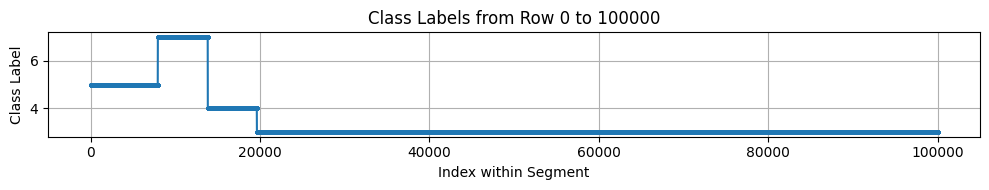

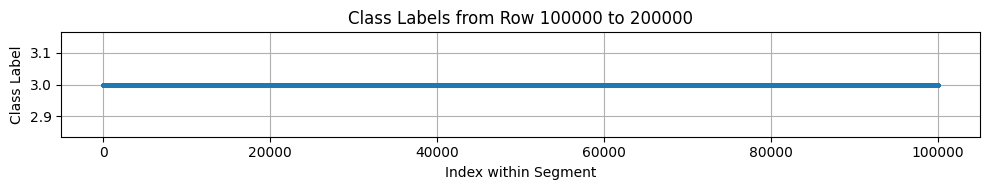

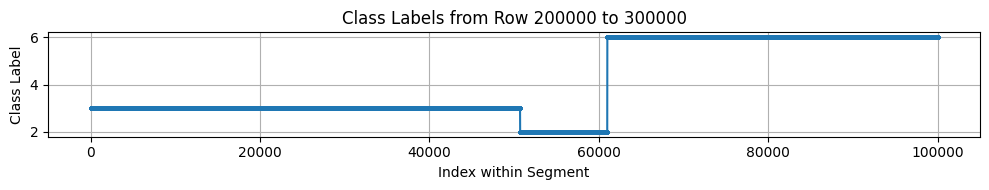

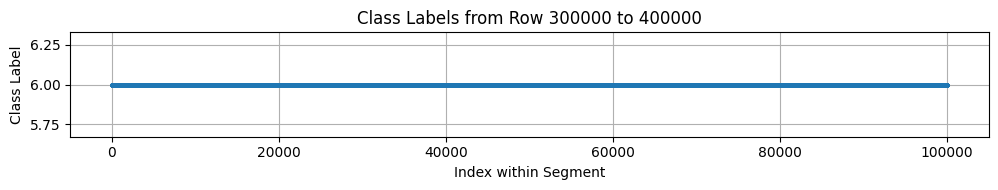

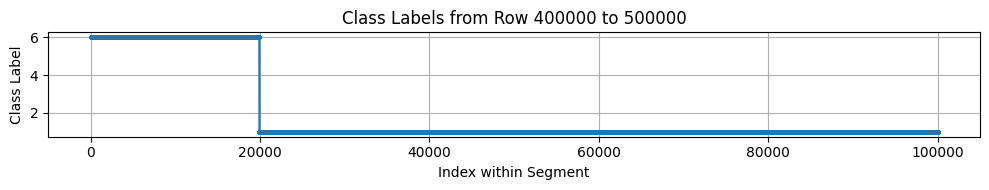

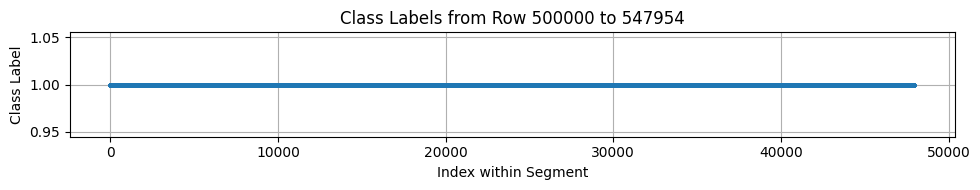

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' and 'y' are loaded from your dataset
X = data['features']  # Features
y = data['labels']    # Labels

# Define the segment size
segment_size = 100000

# Calculate the number of segments needed
num_segments = len(y) // segment_size + (1 if len(y) % segment_size != 0 else 0)

# Loop through each segment and plot the labels
for i in range(num_segments):
    start_idx = i * segment_size
    end_idx = start_idx + segment_size
    if end_idx > len(y):
        end_idx = len(y)

    # Extract the segment of labels
    segment_labels = y[start_idx:end_idx]

    # Create a plot for the segment
    plt.figure(figsize=(10, 2))  # Wider plot to better visualize sequences
    plt.plot(segment_labels, label='Class Label', marker='o', linestyle='-', markersize=2)
    plt.title(f"Class Labels from Row {start_idx} to {end_idx}")
    plt.xlabel('Index within Segment')
    plt.ylabel('Class Label')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()


In [ ]:
import numpy as np

# Assuming 'y' is your labels array
y = data['labels']

# Initialize variables to keep track of the sequence start and the current label
start_index = 0
current_label = y[0]

# List to hold the tuples of start and end indices for each sequence
sequences = []

# Iterate through all labels to find where sequences start and end
for i in range(1, len(y)):
    if y[i] != current_label:
        # Sequence has ended, store the start and end index
        sequences.append((start_index, i - 1, current_label))
        # Update the start index and current label
        start_index = i
        current_label = y[i]

# Add the last sequence if it ends at the last label
if start_index != len(y):
    sequences.append((start_index, len(y) - 1, current_label))

# Print the sequences
for start_idx, end_idx, label in sequences:
    print(f"Attack Class {label} starts at index {start_idx} and ends at index {end_idx}")


Train, Val, Test split

In [92]:
"""
import numpy as np

# Function to generate overlapping sequences
def generate_sequences(data, seq_length=10, seq_overlap=5):
    seqs = []
    for i in range(0, len(data) - seq_length + 1, seq_length - seq_overlap):
        seqs.append(data[i:i + seq_length])
    return seqs

# Function to pad sequences
def pad_sequences(seqs, seq_length):
    padded_seqs = []
    for seq in seqs:
        if len(seq) < seq_length:
            # Pad with zeros if the sequence is shorter than required
            padded_seq = np.vstack((seq, np.zeros((seq_length - len(seq), seq.shape[1]))))
        else:
            padded_seq = seq
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)

"""
# Modify generate_sequences to also generate labels for sequences
def generate_sequences(data, labels, seq_length=10, seq_overlap=5):
    seqs = []
    seq_labels = []
    for i in range(0, len(data) - seq_length + 1, seq_length - seq_overlap):
        seqs.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Assuming the label of the sequence is the label of the last item in the sequence
    return seqs, seq_labels

def pad_sequences(seqs, seq_length):
    padded_seqs = []
    for seq in seqs:
        if len(seq) < seq_length:
            padded_seq = np.vstack((seq, np.zeros((seq_length - len(seq), seq.shape[1]))))
        else:
            padded_seq = seq
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)



In [93]:
X = pd.DataFrame(data['features'])  # Convert features into a DataFrame
y = pd.Series(data['labels'])  


print(X.shape)
print(y.shape)

(547954, 42)
(547954,)


In [94]:
def split_data_by_class(data, labels, train_frac=0.7, val_frac=0.15):
    unique_classes = np.unique(labels)
    train_indices, val_indices, test_indices = [], [], []

    for cls in unique_classes:
        class_indices = np.where(labels == cls)[0]
        np.random.shuffle(class_indices)  # Optional: shuffle indices to randomize selection
        train_end = int(len(class_indices) * train_frac)
        val_end = train_end + int(len(class_indices) * val_frac)

        train_indices.extend(class_indices[:train_end])
        val_indices.extend(class_indices[train_end:val_end])
        test_indices.extend(class_indices[val_end:])

    return data.iloc[train_indices], labels.iloc[train_indices], data.iloc[val_indices], labels.iloc[val_indices], data.iloc[test_indices], labels.iloc[test_indices]

# Assuming data and labels are loaded into X and y
X_train, y_train, X_val, y_val, X_test, y_test = split_data_by_class(X, y)
"""
# Generate sequences for each set
train_seqs = generate_sequences(X_train)
val_seqs = generate_sequences(X_val)
test_seqs = generate_sequences(X_test)
"""
train_seqs, train_seq_labels = generate_sequences(X_train.values, y_train.values)
val_seqs, val_seq_labels = generate_sequences(X_val.values, y_val.values)
test_seqs, test_seq_labels = generate_sequences(X_test.values, y_test.values)


# Pad sequences to ensure uniformity
train_seqs = pad_sequences(train_seqs, seq_length=10)
val_seqs = pad_sequences(val_seqs, seq_length=10)
test_seqs = pad_sequences(test_seqs, seq_length=10)

print(X_train.shape)
print(y_train.shape)


(383565, 42)
(383565,)


In [95]:
# Check if the standard deviation of any feature is zero
std = np.std(train_seqs, axis=(0, 1))
if np.any(std == 0):
    print("Zero standard deviation found in features:", np.where(std == 0))

#REMOVE ?

Zero standard deviation found in features: (array([15, 17, 29, 30, 31, 32, 33, 34], dtype=int64),)


In [107]:
def normalize_data(train, val, test):
    mean = np.mean(train, axis=(0, 1))
    print("\nmean",mean)

    std = np.std(train, axis=(0, 1))
    print("\nmean",std)

    # Avoid division by zero: replace zero std with 1
    std[std == 0] = 1

    normalized_train = (train - mean) / std
    normalized_val = (val - mean) / std
    normalized_test = (test - mean) / std

    return normalized_train, normalized_val, normalized_test


train_X, val_X, test_X = normalize_data(train_seqs, val_seqs, test_seqs)

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
"""
train_y = to_categorical(y_train)
val_y = to_categorical(y_val)
test_y = to_categorical(y_test)
"""

# Convert label lists to NumPy arrays and subtract 1 for proper one-hot encoding
train_seq_labels = np.array(train_seq_labels) - 1  # Convert and adjust
val_seq_labels = np.array(val_seq_labels) - 1      # Convert and adjust
test_seq_labels = np.array(test_seq_labels) - 1    # Convert and adjust

# Now apply to_categorical
train_y = to_categorical(train_seq_labels, 7)
val_y = to_categorical(val_seq_labels, 7)
test_y = to_categorical(test_seq_labels, 7)


"""
# Assuming 'multiclass_model_predictions' are the output of your multiclass classifier
predicted_classes = np.argmax(multiclass_model_predictions, axis=1) + 1  # Add 1 to shift labels back to 1-7

"""


print(train_X.shape)
print(train_y.shape)


mean [-0.30251599  0.43214656 -0.0071984  -0.040559   -0.13262795 -0.30594404
  1.01610603 -0.57040977  0.34489319  0.68380633  0.01809874 -0.04045581
  0.00344279  0.31909552 -0.16974303  0.         -0.01056754  0.
  0.00124247  0.00163327  0.09341123  0.06387345 -0.62513747  0.39036366
 -0.01559586  0.34854081  0.26082964 -0.30246426 -0.09879487  0.
  0.          0.          0.          0.          0.          0.01556358
 -0.21182333  0.00255652 -0.01398662 -0.05906157 -0.06749402  0.20718232]

mean [4.47656907e-01 1.25963045e+00 4.10815829e-03 3.17013314e-02
 2.28254224e-01 5.82985819e-02 1.77483654e+00 2.00166998e-01
 1.22776363e+00 1.53183995e+00 1.29877994e+00 9.30325112e-01
 8.03830508e-01 1.76526422e+00 4.87879356e-01 0.00000000e+00
 7.60988494e-14 0.00000000e+00 4.58429628e-06 7.96110689e-05
 1.22611589e+00 1.00794963e+00 6.92865015e-02 1.67553342e+00
 9.10348186e-14 1.09050881e+00 1.06688757e+00 2.65669909e-01
 8.67575085e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

CHECK

In [ ]:
#to check class distribution 

def check_class_distribution(labels, dataset_name="Dataset"):
    import numpy as np
    unique_classes, counts = np.unique(labels, return_counts=True)
    print(f"{dataset_name} - Class Distribution:")
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} instances")
    return unique_classes

# Example usage with y_train, y_val, y_test which are the label arrays for training, validation, and test sets
train_classes = check_class_distribution(y_train, "Training Set")
val_classes = check_class_distribution(y_val, "Validation Set")
test_classes = check_class_distribution(y_test, "Test Set")


In [81]:
# Assuming y_train is a pandas Series
unique_values = y_val.unique()
print("Unique values in y_train:", unique_values)


Unique values in y_train: [1 2 3 4 5 6 7]


MODEL

In [106]:
test_y.shape


(16439, 7)

Class 0.0: 98634 data points
Class 1.0: 16439 data points
Class Distribution in Test Set:
[[0.0000e+00 9.8634e+04]
 [1.0000e+00 1.6439e+04]]


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Activation , Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Assuming 'train_X', 'val_X', 'test_X' are loaded and properly shaped for LSTM input
# Check shapes of the inputs
print("Training data shape:", train_X.shape)
print("Validation data shape:", val_X.shape)
print("Test data shape:", test_X.shape)

# Check if scaling is needed or adjust based on already scaled data
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
val_X = scaler.transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)

# Model configuration
n_features = train_X.shape[2]  # Assuming train_X is [samples, time steps, features]


print(train_X.shape)
print(train_y.shape)

Training data shape: (76712, 10, 42)
Validation data shape: (16436, 10, 42)
Test data shape: (16439, 10, 42)
(76712, 10, 42)
(76712, 7)


In [98]:
model = Sequential([
    Input(shape=(None, 42)),  # Set 'None' for sequence length to allow variable-length sequences
    Conv1D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Assuming 15 classes in your output
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, None, 64)       │         8,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, None, 128)      │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 256)            │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,399 (1.29 MB)

 Trainable params: 339,271 (1.29 MB)

 Non-trainable params: 128 (512.00 B)

In [99]:
print(train_X.shape)
print(train_y.shape)

(76712, 10, 42)
(76712, 7)


In [100]:
# Training the model
model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(val_X, val_y))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9923 - loss: 0.0432 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 2/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0028
Epoch 3/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.9997 - val_loss: 0.0024
Epoch 4/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 5/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9999 - loss: 4.3579e-04 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 6/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9999 - loss: 5.7691e-04 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 7/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 1.0000 - loss: 3.3484e-05 - val_accuracy: 0.9998 - val_loss: 0.0024
Epoch 8/20
2398/2398 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 1.00

In [103]:
model.save('models/best_multiclass.keras')

#LOAD MODEL HERE
from tensorflow.keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('models/best_multiclass.keras')



In [88]:
print("Shape of train_y:", train_y.shape)
print("Shape of val_y:", val_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_y: (76712, 7, 2, 2)
Shape of val_y: (16436, 7, 2, 2)
Shape of test_y: (16439, 7, 2, 2)
